In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from tensorflow.keras.models import Model

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold


## Load Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'a-large-scale-fish-dataset' dataset.
Path to dataset files: /kaggle/input/a-large-scale-fish-dataset


## Preprocess Dataset

In [4]:
# Main dataset directory
base_dir = os.path.join(path, "Fish_Dataset", "Fish_Dataset")

X = []  # images
y = []  # labels

# Loop through each fish species
for species in os.listdir(base_dir):
    species_path = os.path.join(base_dir, species)
    if not os.path.isdir(species_path):
        continue

    # Loop inside each fish species folder
    for subfolder in os.listdir(species_path):
        subfolder_path = os.path.join(species_path, subfolder)

        # Skip mask folders (GT = Ground Truth)
        if "GT" in subfolder or not os.path.isdir(subfolder_path):
            continue

        # Read image files
        for img_file in os.listdir(subfolder_path):
            if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(subfolder_path, img_file)

                # Read and preprocess
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 128))  # resize to standard shape

                X.append(img)
                y.append(species)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)


print("Total images:", len(X))
print("Classes:", np.unique(y))
print("Image shape:", X[0].shape)


Total images: 9000
Classes: ['Black Sea Sprat' 'Gilt-Head Bream' 'Hourse Mackerel' 'Red Mullet'
 'Red Sea Bream' 'Sea Bass' 'Shrimp' 'Striped Red Mullet' 'Trout']
Image shape: (128, 128, 3)


In [5]:
# Encode string labels (species names) → integers
le = LabelEncoder()
y_int = le.fit_transform(y)

num_classes = len(le.classes_)
print("Number of classes:", num_classes)
print("Class mapping:", dict(zip(le.classes_, range(num_classes))))

# Split: e.g. 80% train, 20% test  (no validation)
X_train, X_test, y_train_int, y_test_int = train_test_split(
    X, y_int, test_size=0.20, random_state=42, stratify=y_int
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# One-hot encode labels
y_train = to_categorical(y_train_int, num_classes)
y_test  = to_categorical(y_test_int, num_classes)


Number of classes: 9
Class mapping: {np.str_('Black Sea Sprat'): 0, np.str_('Gilt-Head Bream'): 1, np.str_('Hourse Mackerel'): 2, np.str_('Red Mullet'): 3, np.str_('Red Sea Bream'): 4, np.str_('Sea Bass'): 5, np.str_('Shrimp'): 6, np.str_('Striped Red Mullet'): 7, np.str_('Trout'): 8}
Train: (7200, 128, 128, 3) Test: (1800, 128, 128, 3)


In [6]:
# Convert to float32
X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")

# Apply InceptionV3 preprocessing
X_train_prep = preprocess_input(X_train)
X_test_prep  = preprocess_input(X_test)

# InceptionV3 with 5-Fold Cross-Validation

In [7]:
input_shape = (128, 128, 3)

# --- Cross-Validation Setup ---
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Lists to store metrics and history from each fold
fold_acc_scores = []
fold_loss_scores = []
# NEW: List to store the history object for each fold
fold_histories = []

# Variable to track the best fold accuracy and its index
best_fold_acc = 0.0
best_fold_idx_0_indexed = -1 # Will store the 0-indexed index of the best fold

print(f"{N_SPLITS}-Fold Cross-Validation")

# Loop through each fold
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_prep, y_train_int)):
    print(f"\n--- Fold {fold_idx + 1}/{N_SPLITS} ---")

    # Get the train and validation data for this fold
    X_fold_train, X_fold_val = X_train_prep[train_index], X_train_prep[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

    # --- Rebuild Model for Each Fold ---
    # It's crucial to rebuild the model to reset weights for each fold
    base_model_cv = InceptionV3(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    for layer in base_model_cv.layers:
        layer.trainable = False

    x = base_model_cv.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model_cv = Model(inputs=base_model_cv.input, outputs=outputs)

    model_cv.compile(
        optimizer= Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Model Training for the fold
    history = model_cv.fit(
        X_fold_train, y_fold_train,
         epochs=30,
        batch_size=32,
        validation_data=(X_fold_val, y_fold_val),
        verbose=0
    )

    # Store history object for later plotting
    fold_histories.append(history)

    # Model Evaluation for the fold (on the last epoch)
    val_loss, val_acc = model_cv.evaluate(X_fold_val, y_fold_val, verbose=0)
    print(f"Fold {fold_idx + 1} - Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

    fold_acc_scores.append(val_acc)
    fold_loss_scores.append(val_loss)

    # --- Logic to track the best fold ---
    if val_acc > best_fold_acc:
        best_fold_acc = val_acc
        best_fold_idx_0_indexed = fold_idx # Update the 0-indexed index of the best fold
        best_history = history

        # Compute predictions for this best fold
        y_proba = model_cv.predict(X_fold_val, verbose=0)
        best_y_pred = np.argmax(y_proba, axis=1)
        best_y_true = np.argmax(y_fold_val, axis=1)


# --- Cross-Validation Results Summary (Optional but helpful) ---
print("\n" + "="*50)
print(f"Best Fold: {best_fold_idx_0_indexed + 1} with Accuracy: {best_fold_acc:.4f}")
print("="*50)



5-Fold Cross-Validation

--- Fold 1/5 ---
Fold 1 - Validation Accuracy: 0.9604, Loss: 0.1441

--- Fold 2/5 ---
Fold 2 - Validation Accuracy: 0.9528, Loss: 0.1724

--- Fold 3/5 ---
Fold 3 - Validation Accuracy: 0.9569, Loss: 0.2013

--- Fold 4/5 ---
Fold 4 - Validation Accuracy: 0.9625, Loss: 0.1432

--- Fold 5/5 ---
Fold 5 - Validation Accuracy: 0.9417, Loss: 0.2246

Best Fold: 4 with Accuracy: 0.9625


In [8]:
from sklearn.metrics import classification_report

print("\n--- Classification Report (Best Fold) ---")
print(classification_report(best_y_true, best_y_pred, digits=4))



--- Classification Report (Best Fold) ---
              precision    recall  f1-score   support

           0     0.9455    0.9750    0.9600       160
           1     0.9745    0.9563    0.9653       160
           2     0.9873    0.9750    0.9811       160
           3     0.9625    0.9625    0.9625       160
           4     0.9573    0.9812    0.9691       160
           5     0.9434    0.9375    0.9404       160
           6     0.9581    1.0000    0.9786       160
           7     0.9667    0.9062    0.9355       160
           8     0.9688    0.9688    0.9688       160

    accuracy                         0.9625      1440
   macro avg     0.9627    0.9625    0.9624      1440
weighted avg     0.9627    0.9625    0.9624      1440



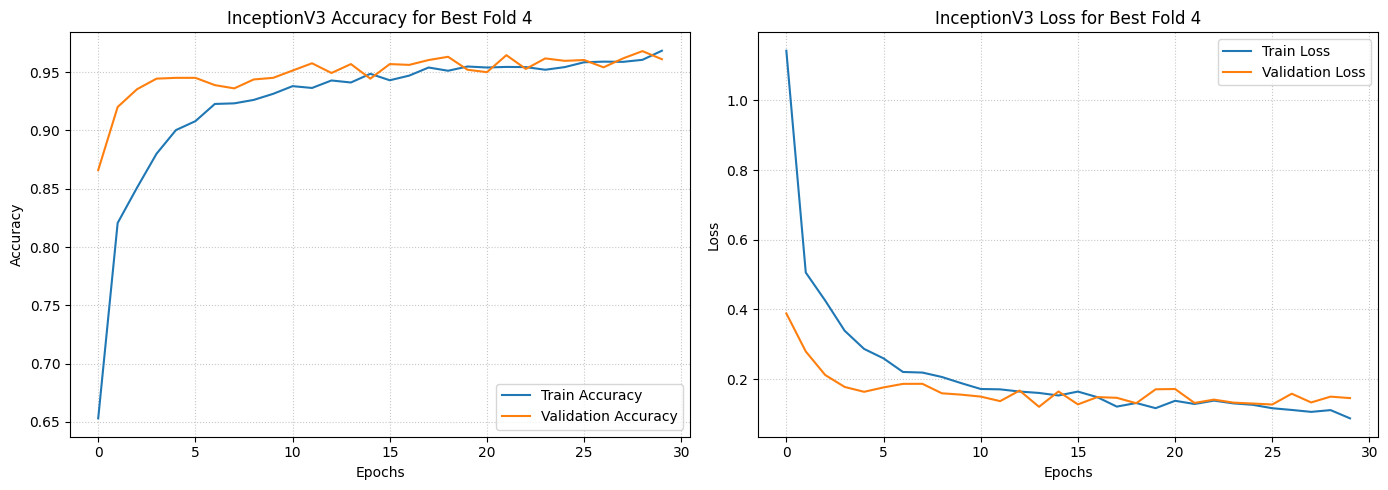

In [ ]:
# --- Plotting the Best Fold History ---

# Retrieve the history object for the best fold
best_fold_history = fold_histories[best_fold_idx_0_indexed]
history_dict = best_fold_history.history

# Extract metrics
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs_range = range(30)

# Create the plot figure
plt.figure(figsize=(14, 5))


# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title(f'InceptionV3 Accuracy for Best Fold {best_fold_idx_0_indexed + 1}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.7)


# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title(f'InceptionV3 Loss for Best Fold {best_fold_idx_0_indexed + 1}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()